In [23]:
import anndata as ad
import torch
import vapor
from vapor.config import VAPORConfig

In [2]:
# Load data
adata = ad.read_h5ad('../data/drugSeries.h5ad')

# Filter data
valid_treatments = ['DMSO_48hr']
valid_treatments += [f'Tram_{i}hr' for i in (3, 6, 12, 24, 48)]  # Maybe hold out 24?
mask = adata.obs['treatment'].isin(valid_treatments)
adata = adata[mask]

# Annotate timepoints
timepoint_dict = {k: v for k, v in zip(valid_treatments, (0, 3, 6, 12, 24, 48))}  # Should this be scaled?
adata.obs['Timepoint'] = adata.obs['treatment'].apply(lambda x: timepoint_dict[x])

/tmp/ipykernel_25239/4161362362.py:12: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Timepoint'] = adata.obs['treatment'].apply(lambda x: timepoint_dict[x])


In [3]:
# Create supervised dataset
dataset = vapor.dataset_from_adata(
    adata,
    root_where=['treatment=DMSO_48hr'],
    terminal_where=['treatment=Tram_48hr'],
    time_label='Timepoint',
    root_n=200, terminal_n=200, seed=42,
    scale=True)

Time Range: (0.000, 1.000)
Data scaled per row.
Root selection: matched=2256, sampled=200, where={'treatment': 'DMSO_48hr'}
Terminal selection: matched=1439, sampled=200, where={'treatment': 'Tram_48hr'}


In [5]:
# Config
config = VAPORConfig(
    latent_dim=64, n_dynamics=10, lr=5e-4,
    beta=0.01, eta=1.0, t_max=4, epochs=500,
    batch_size=512, device='cuda')

# Initialize model
model = vapor.initialize_model(adata.n_vars, config=config)

Initializing model:
  Input dim: 32738
  Latent dim: 64
  Encoder dims: [2048, 512, 128]
  Decoder dims: [128, 512, 2048]
  N dynamics: 10
0.75


Training on device: cuda
Training for 500 epochs with batch size 512
Data split: train=6598, test=1650 (test_size=0.2)

Starting training...
--------------------------------------------------------------------------------
Epoch   1/500 | Time:  4.77s | Recon: 1.9963 | KL: 0.1235 | Traj: 1.8813 | Prior: 0.0849 | Psi: 0.9986
Epoch   2/500 | Time:  4.25s | Recon: 1.9856 | KL: 0.1233 | Traj: 1.9020 | Prior: 0.0700 | Psi: 0.9938
Epoch   3/500 | Time:  4.22s | Recon: 1.9756 | KL: 0.1233 | Traj: 1.8847 | Prior: 0.0653 | Psi: 0.9862
Epoch   4/500 | Time:  4.26s | Recon: 1.9656 | KL: 0.1232 | Traj: 1.8668 | Prior: 0.0640 | Psi: 0.9786
Epoch   5/500 | Time:  4.24s | Recon: 1.9555 | KL: 0.1232 | Traj: 1.8864 | Prior: 0.0537 | Psi: 0.9690
Epoch   6/500 | Time:  4.24s | Recon: 1.9463 | KL: 0.1232 | Traj: 1.8718 | Prior: 0.0444 | Psi: 0.9600
Epoch   7/500 | Time:  4.23s | Recon: 1.9372 | KL: 0.1232 | Traj: 1.8809 | Prior: 0.0401 | Psi: 0.9485
Epoch   8/500 | Time:  4.25s | Recon: 1.9280 | KL: 0.1232

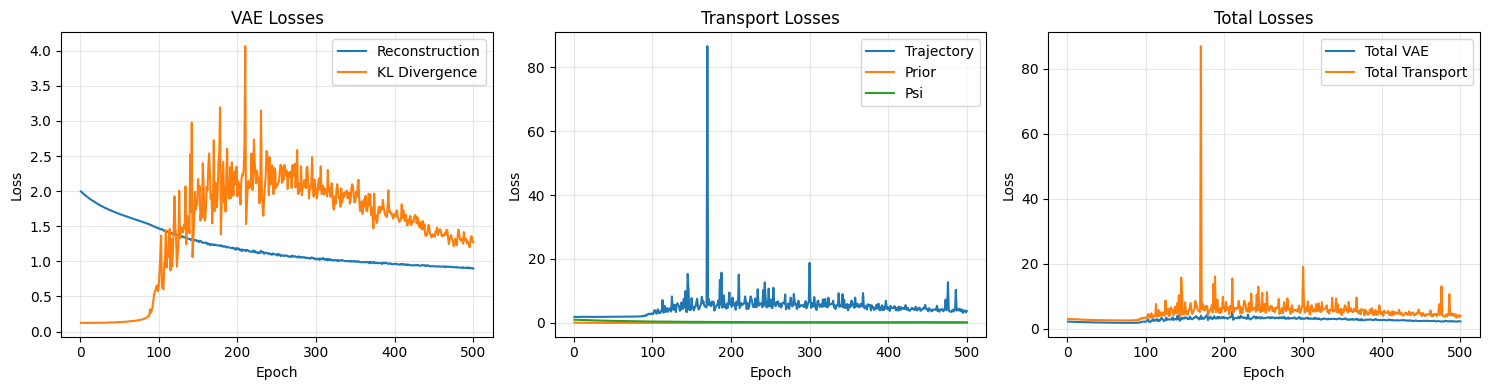

In [ ]:
# Load model
# model.load_state_dict(torch.load('./trained_model.h5'))
# trained_model = model

# Train
trained_model = vapor.train_model(model, dataset, config=config)

In [ ]:
# Save model
torch.save(trained_model, './trained_model.h5')

<Axes: title={'center': 'Timepoint'}, xlabel='UMAP1', ylabel='UMAP2'>

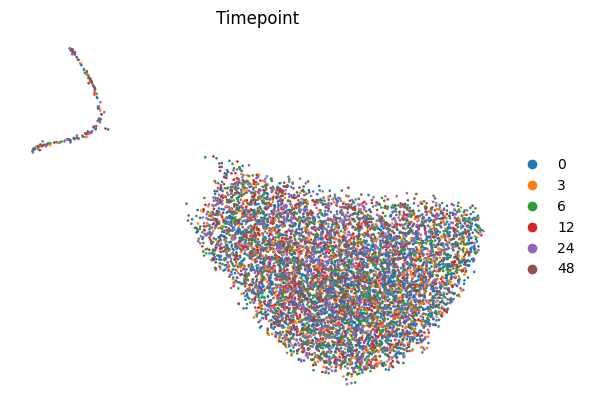

In [ ]:
import scanpy as sc
from vapor.inference import extract_latents_and_dynamics
adata_VAPOR = extract_latents_and_dynamics(trained_model, adata, scale=True, device='cpu')

n_neighbors = 20  # 200 results in error
sc.pp.neighbors(adata_VAPOR, n_neighbors=n_neighbors, random_state=42, use_rep='X')
sc.tl.umap(adata_VAPOR)
sc.pl.embedding(adata_VAPOR, basis='umap', color=['Timepoint'], frameon=False, show=False)

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_VAPOR_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_VAPOR_umap', embedded velocity vectors (adata.obsm)


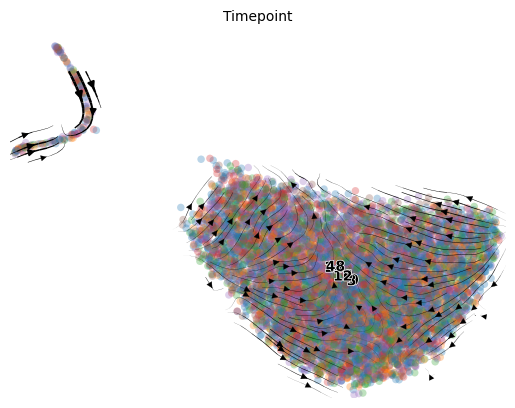

In [19]:
import scvelo as scv
sc.pp.neighbors(adata_VAPOR,use_rep='X_VAPOR', random_state=42, n_neighbors=n_neighbors)
scv.tl.velocity_graph(adata_VAPOR, vkey='v_VAPOR', xkey='vapor')
scv.pl.velocity_embedding_stream(adata_VAPOR, vkey='v_VAPOR', basis='umap',color=['Timepoint'])

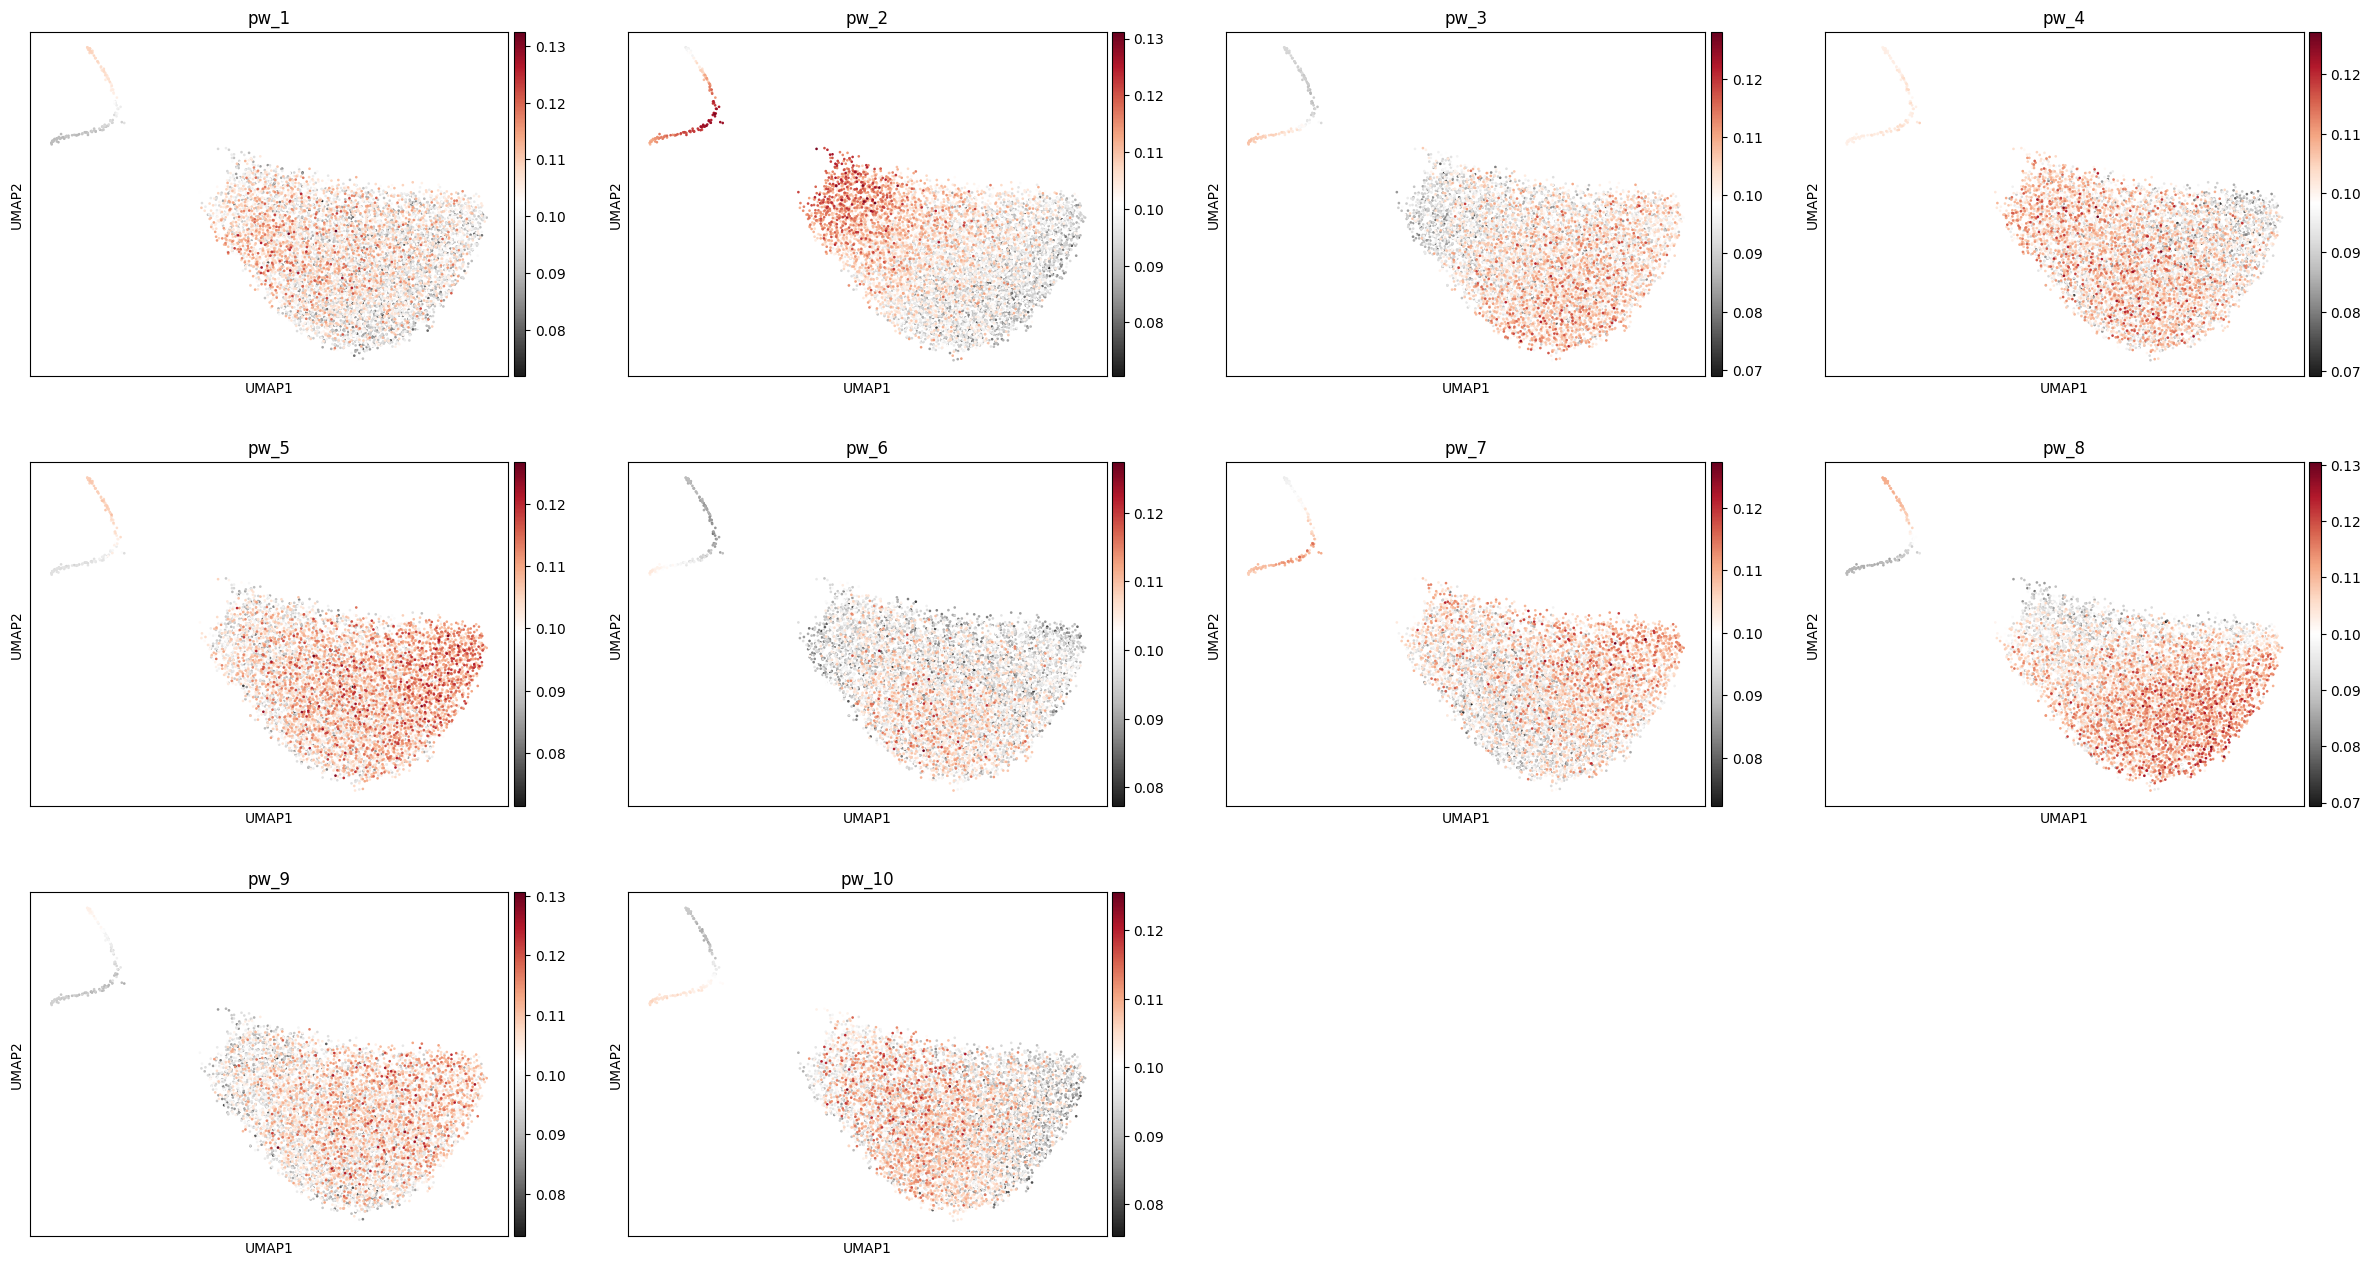

In [20]:
n_dynamics = model.transport_op.n_dynamics
sc.pl.embedding(
    adata_VAPOR,
    color=[f"pw_{i+1}" for i in range(n_dynamics)],
    basis="umap",
    cmap='RdGy_r',
)

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi1_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi1_umap', embedded velocity vectors (adata.obsm)


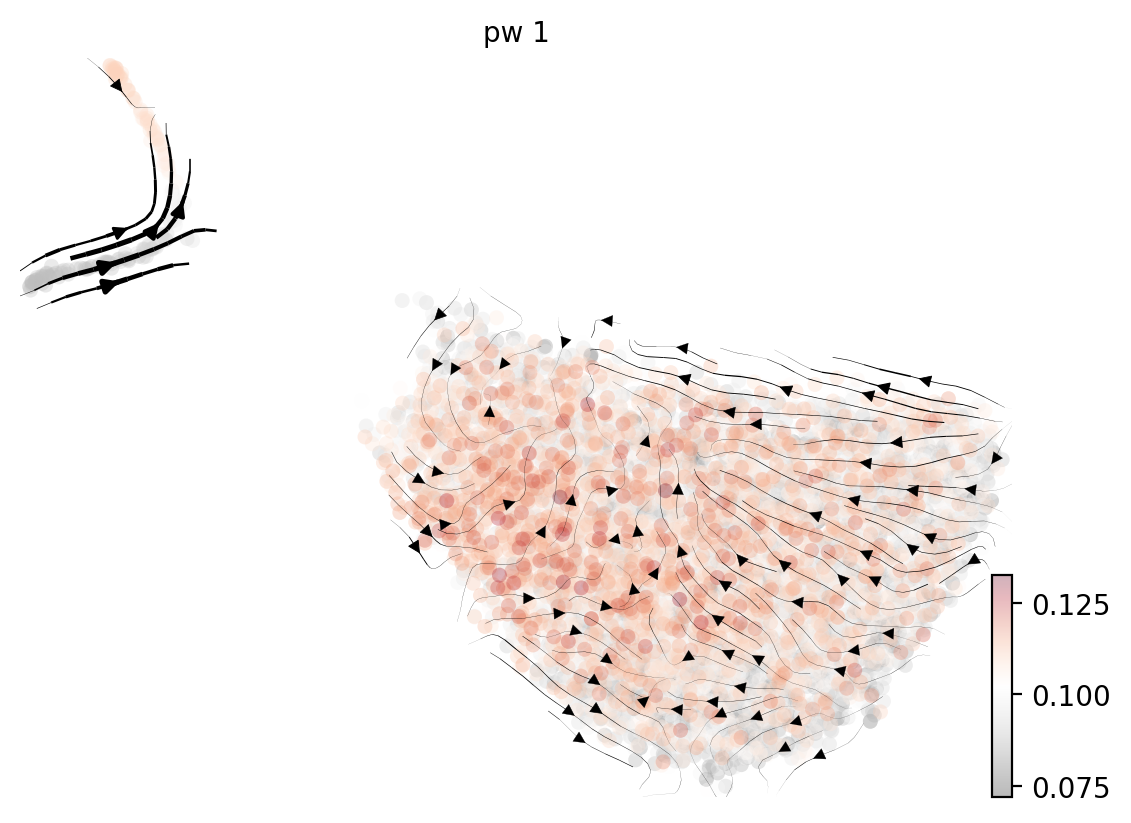

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi2_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi2_umap', embedded velocity vectors (adata.obsm)


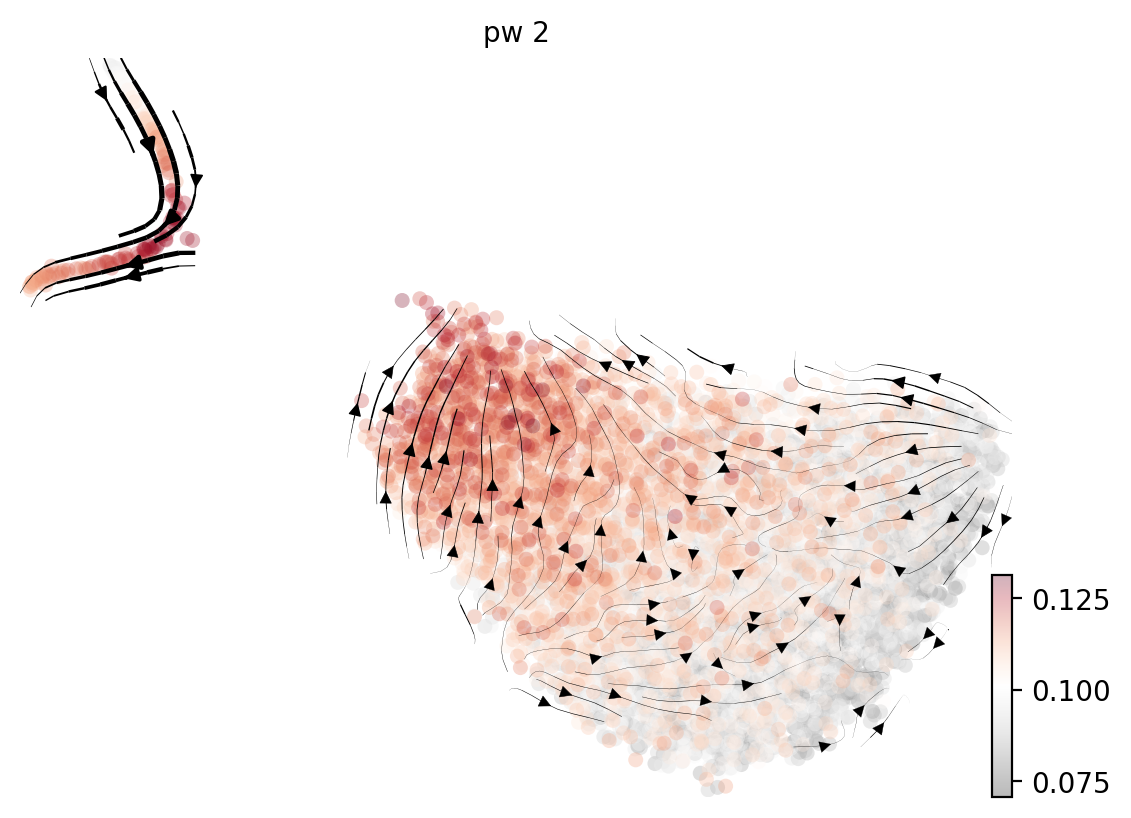

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi3_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi3_umap', embedded velocity vectors (adata.obsm)


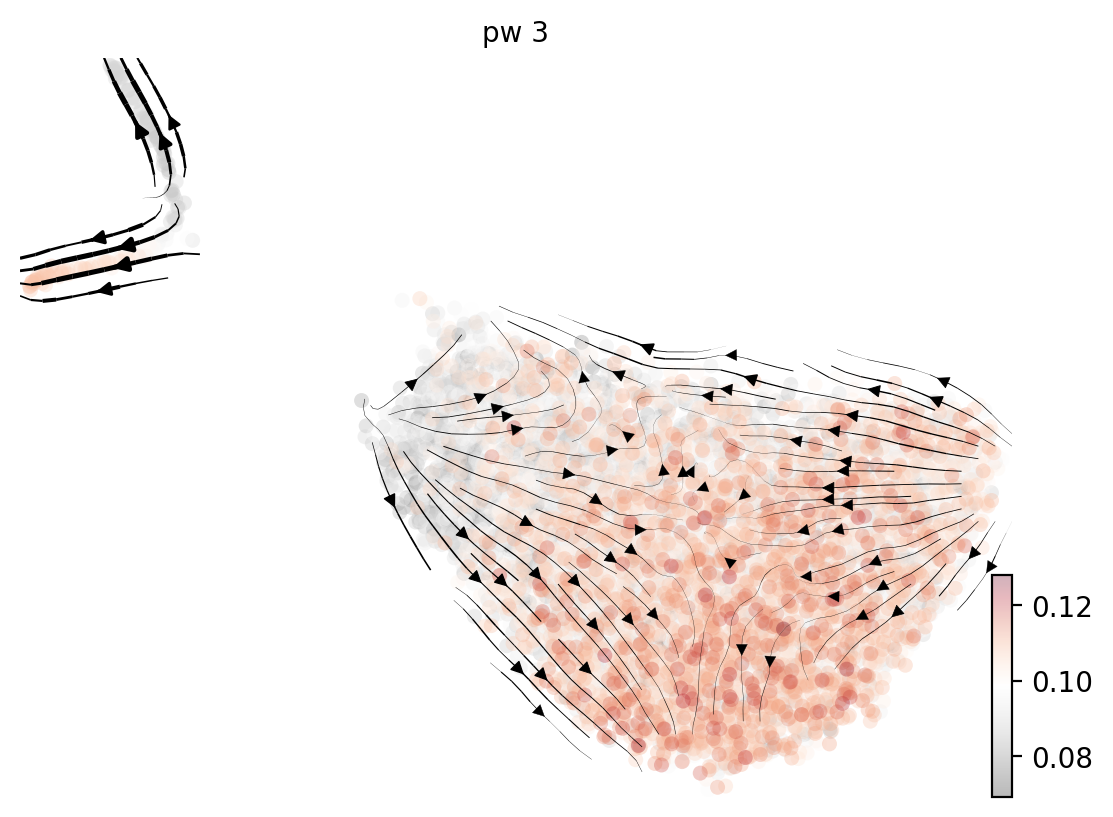

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi4_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi4_umap', embedded velocity vectors (adata.obsm)


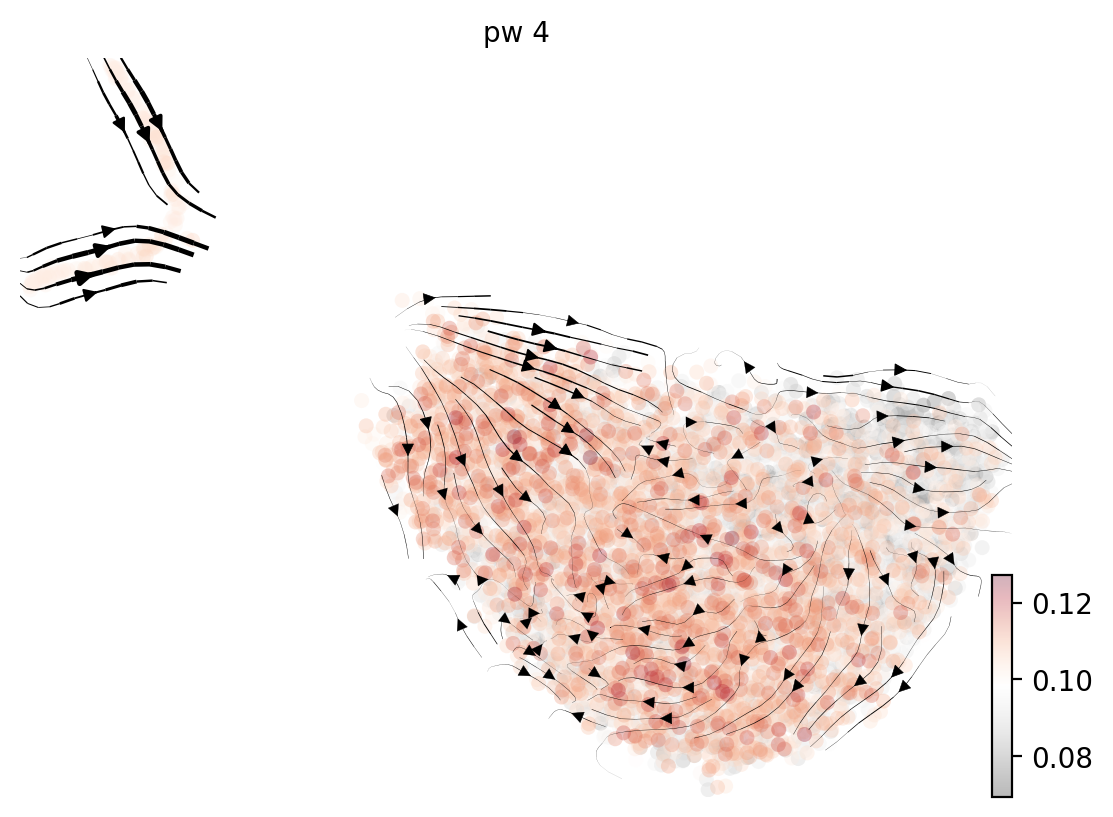

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi5_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi5_umap', embedded velocity vectors (adata.obsm)


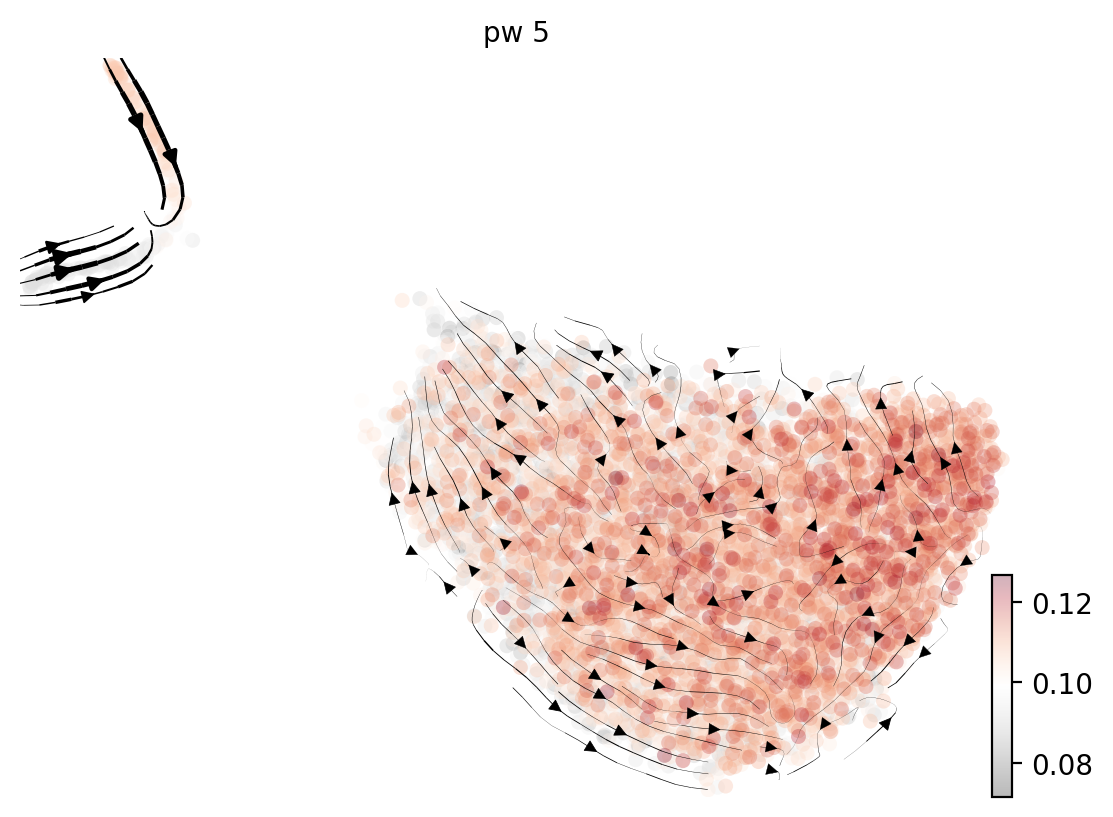

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi6_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi6_umap', embedded velocity vectors (adata.obsm)


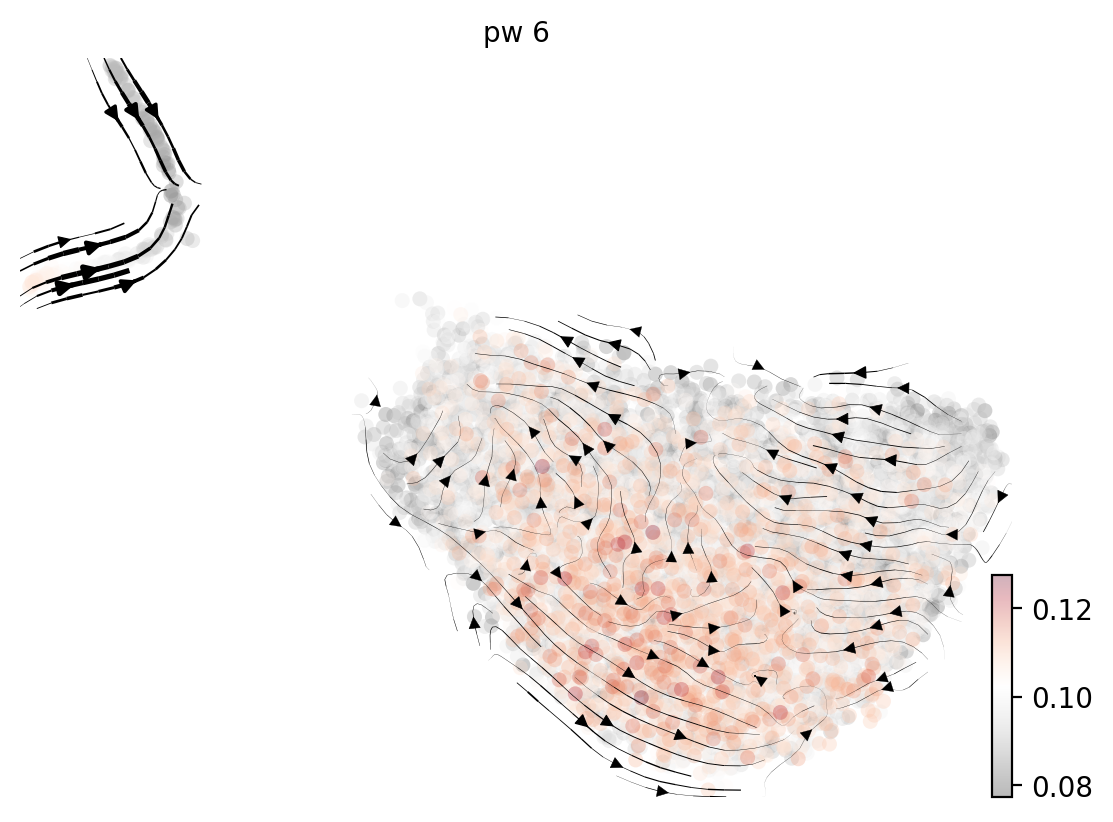

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi7_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi7_umap', embedded velocity vectors (adata.obsm)


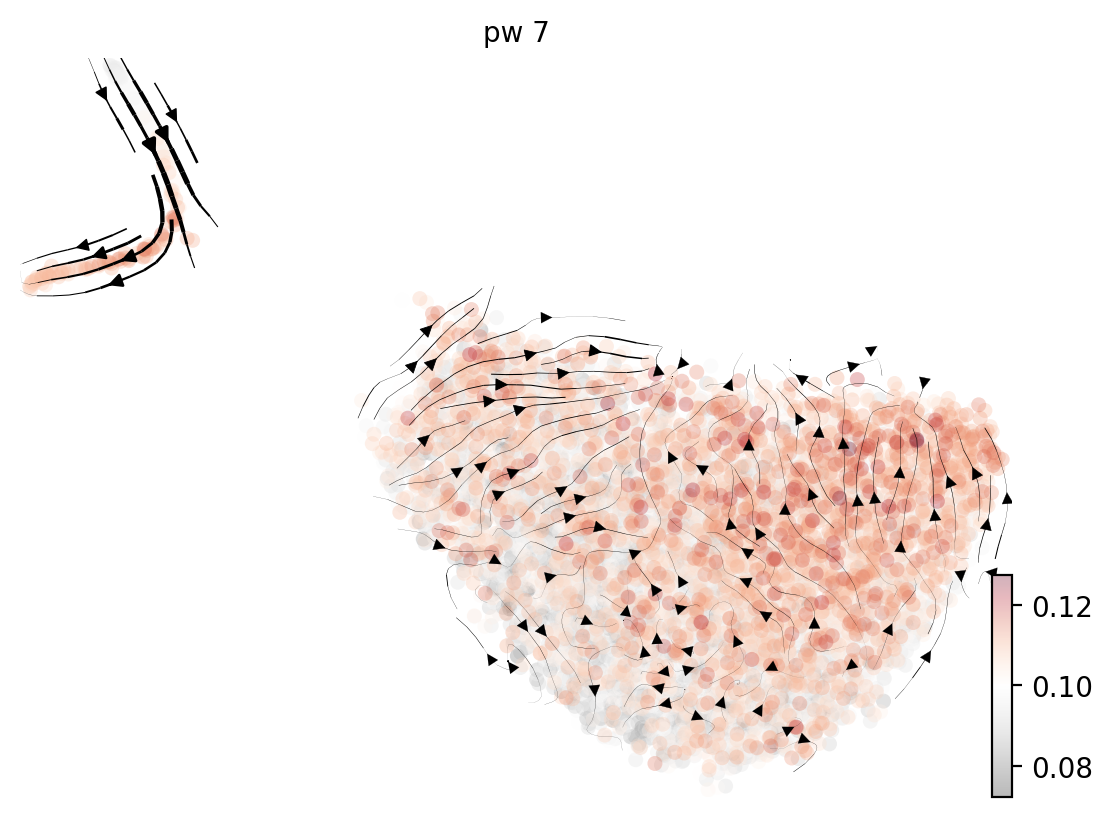

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi8_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi8_umap', embedded velocity vectors (adata.obsm)


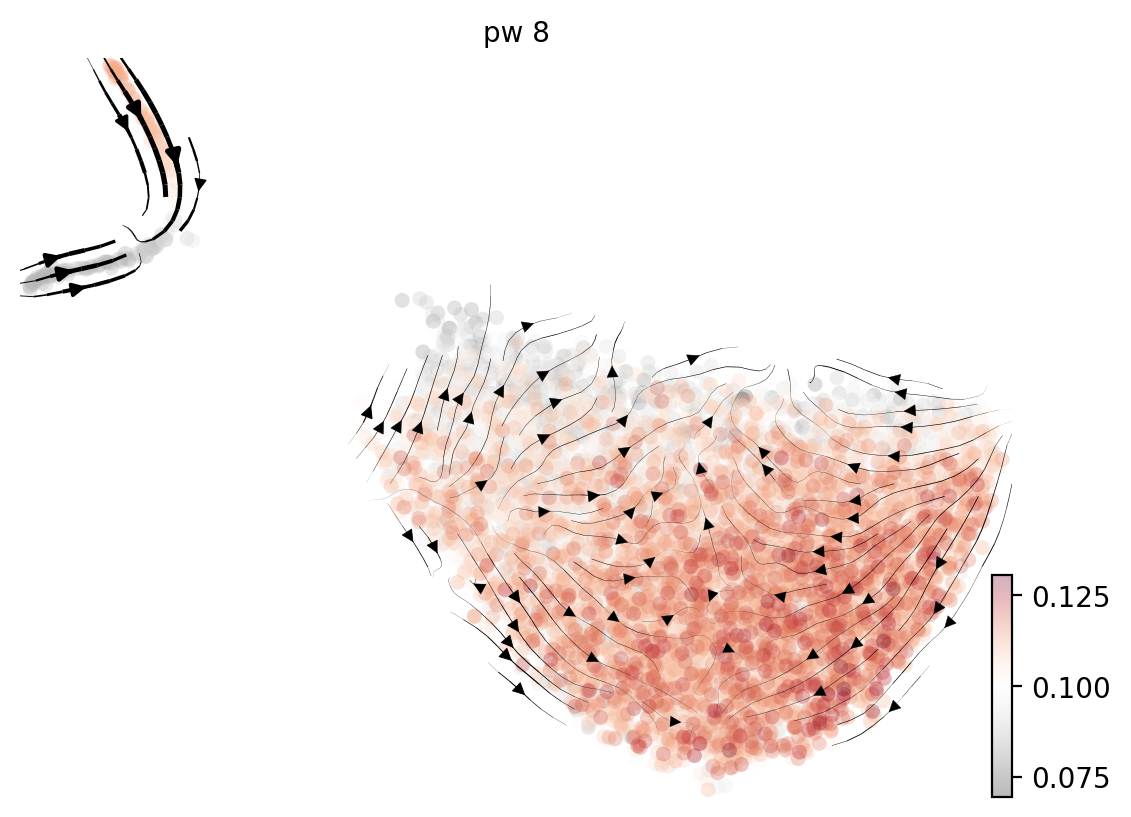

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi9_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi9_umap', embedded velocity vectors (adata.obsm)


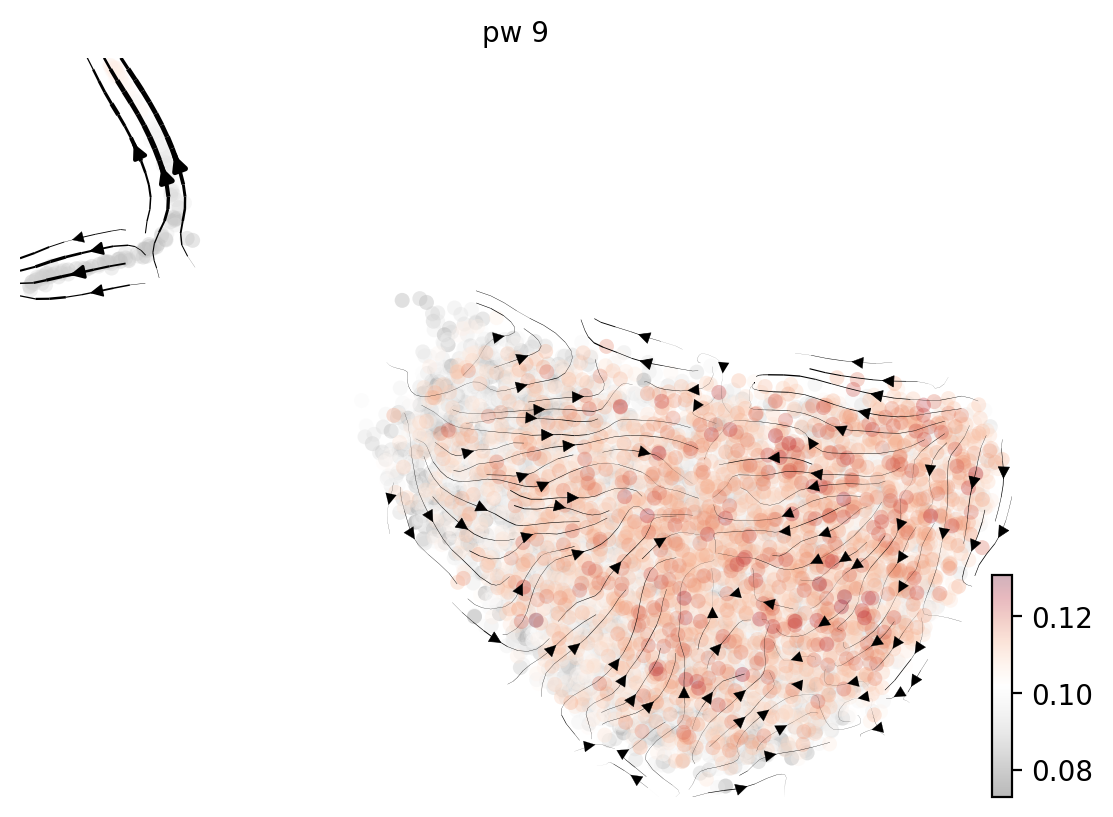

computing velocity graph (using 1/8 cores)
    finished (0:00:04) --> added 
    'v_psi10_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'v_psi10_umap', embedded velocity vectors (adata.obsm)


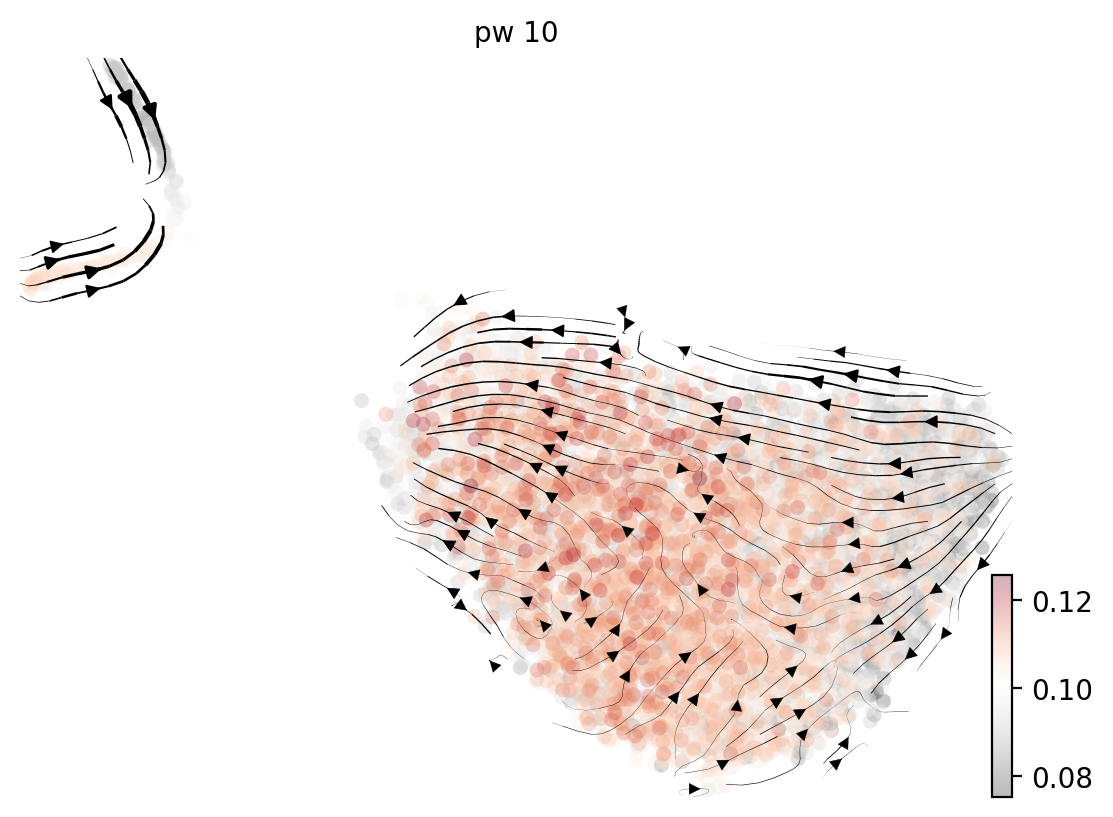

In [21]:
for i in range(n_dynamics):
    sc.pp.neighbors(adata_VAPOR, use_rep='X_VAPOR', random_state=0, n_neighbors=n_neighbors)
    scv.tl.velocity_graph(adata_VAPOR, vkey=f'v_psi{i+1}', xkey='vapor')
    scv.pl.velocity_embedding_stream(
        adata_VAPOR,
        basis='umap',
        vkey=f'v_psi{i+1}',
        color=[f'pw_{i+1}'],
        cmap='RdGy_r',
        show=True,
        n_neighbors=50,
        dpi=200
    )

